In [1]:
# ============================
# 1. Load and preprocess data
# ============================
import pandas as pd
import numpy as np
import ast
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix, average_precision_score, precision_recall_curve
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [2]:
# Load dataset (processed data)
data = pd.read_csv("dataset.csv")

print(data.head(1))

           gene_id    transcript_id  transcript_position  label  \
0  ENSG00000004059  ENST00000000233                  244      0   

   transcript_id.1  transcript_position.1 nucleotide  \
0  ENST00000000233                    244    AAGACCA   

                                               reads  
0  [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0...  


In [41]:
# =========================
# 1. Extract 3×5-mers
# =========================
def extract_3x5mers(seq):
    """Given 7-mer, extract 3 overlapping 5-mers"""
    if isinstance(seq, str) and len(seq) >= 7:
        return [seq[0:5], seq[1:6], seq[2:7]]
    return [None, None, None]

data["Three_5mers"] = data["nucleotide"].apply(extract_3x5mers)
print("Example 3x5-mers:", data.loc[0, "Three_5mers"])

# =========================
# 2. Extract 9D read features
# =========================
def extract_threepos_reads_all(reads_str):
    """Extract [mu_-1, sd_-1, l_-1, mu0, sd0, l0, mu1, sd1, l1] per read"""
    if pd.isna(reads_str):
        return []

    reads_str = str(reads_str).strip()
    if not (reads_str.startswith("[") and reads_str.endswith("]")):
        reads_str = "[" + reads_str + "]"

    try:
        reads = ast.literal_eval(reads_str)
    except Exception:
        try:
            reads = eval(reads_str)
        except Exception:
            return []

    if not isinstance(reads, list) or len(reads) == 0:
        return []

    full_features = []
    for r in reads:
        if isinstance(r, list) and len(r) >= 9:
            full_features.append(r[:9])
    return full_features

data["ThreePosReads"] = data["reads"].apply(extract_threepos_reads_all)
print("Example read features (first 2):", data.loc[0, "ThreePosReads"][:2])

Example 3x5-mers: ['AAGAC', 'AGACC', 'GACCA']
Example read features (first 2): [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0.0093, 10.9, 84.1], [0.00631, 2.53, 125.0, 0.00844, 4.67, 126.0, 0.0103, 6.3, 80.9]]


In [64]:
# ---------------------------------------------------------
# 1️⃣ Encode 3×5-mer → tensor shape [3,5]
# ---------------------------------------------------------
NUC2IDX = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

def encode_3x5(seq_list):
    """Convert list of 3×5-mers to integer tensor [3,5]."""
    return torch.tensor(
        [[NUC2IDX.get(b, 0) for b in kmer] for kmer in seq_list],
        dtype=torch.long
    )

# ---------------------------------------------------------
# 2️⃣ Normalize and pad reads
# ---------------------------------------------------------
def pad_reads(reads):
    """
    Convert list of read features (Nx9) to tensor.
    Keeps variable number of reads (no fixed MAX_READS).
    Ensures at least one dummy row if reads are empty.
    """
    if len(reads) == 0:
        return torch.zeros((1, 9), dtype=torch.float32)  # avoid empty tensor
    return torch.tensor(reads, dtype=torch.float32)

# --- Global normalization stats ---
all_read_values = np.concatenate(
    [np.array(r) for r in data["ThreePosReads"] if len(r) > 0]
)
mean_vals, std_vals = all_read_values.mean(axis=0), all_read_values.std(axis=0)
print("Normalization mean/std:", mean_vals, std_vals)

def normalize_reads(reads):
    """Normalize 9D read features globally."""
    arr = np.array(reads, dtype=np.float32)
    if arr.ndim != 2 or arr.shape[1] != 9:
        arr = np.zeros((1, 9), dtype=np.float32)
    arr = (arr - mean_vals) / (std_vals + 1e-6)
    return arr

# ---------------------------------------------------------
# 3️⃣ Dataset class
# ---------------------------------------------------------
class RNASet3x5(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        reads = pad_reads(normalize_reads(row["ThreePosReads"]))  # (N,9)
        seq = encode_3x5(row["Three_5mers"])                      # (3,5)
        y = torch.tensor([row["label"]], dtype=torch.float32)
        return reads, seq, y

# ---------------------------------------------------------
# 4️⃣ Custom collate function for variable-length reads
# ---------------------------------------------------------
def collate_fn(batch):
    """
    Pads each reads tensor dynamically to the longest in the batch.
    """
    reads, seqs, labels = zip(*batch)
    max_len = max(r.size(0) for r in reads)

    padded_reads = []
    for r in reads:
        pad_len = max_len - r.size(0)
        if pad_len > 0:
            pad = torch.zeros((pad_len, r.size(1)), dtype=r.dtype)
            r = torch.cat([r, pad], dim=0)
        padded_reads.append(r)

    reads_batch = torch.stack(padded_reads)
    seqs_batch = torch.stack(seqs)
    labels_batch = torch.stack(labels)

    return reads_batch, seqs_batch, labels_batch

# ---------------------------------------------------------
# 5️⃣ Data splits + loaders
# ---------------------------------------------------------
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data["label"]
)

train_ds = RNASet3x5(train_df)
test_ds  = RNASet3x5(test_df)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dl  = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

print("✅ Dataloaders ready — dynamic padding enabled")

Normalization mean/std: [8.10645743e-03 4.34753139e+00 1.10902472e+02 8.14936419e-03
 5.18295743e+00 1.11081581e+02 7.07734067e-03 2.98114081e+00
 8.62538202e+01] [5.41198045e-03 2.57792456e+00 1.19263891e+01 5.30142693e-03
 3.00862939e+00 1.30279960e+01 4.38576153e-03 1.69963546e+00
 5.55648401e+00]
✅ Dataloaders ready — dynamic padding enabled


In [ ]:
class SeqEmbedding3x5(nn.Module):
    def __init__(self, vocab_size=4, emb_dim=8, k=5, num_pos=3, out_dim=16):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, num_pos, 1, emb_dim))  # position encoding
        self.conv = nn.Conv1d(in_channels=k * emb_dim, out_channels=64, kernel_size=2, padding=1)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(64, out_dim),
            nn.ReLU()
        )

    def forward(self, seq):  # [B, 3, 5]
        e = self.emb(seq) + self.pos_emb           # [B,3,5,emb_dim]
        e = e.view(e.size(0), e.size(1), -1)       # [B,3,5*emb_dim]
        e = e.transpose(1, 2)                      # [B,5*emb_dim,3]
        e = self.conv(e).mean(dim=-1)              # [B,64]
        return self.fc(e)

class ReadFeatureEncoder(nn.Module):
    def __init__(self, input_dim=9, seq_dim=16, hidden_dim=64, out_dim=32):
        super().__init__()
        self.fc_seq = nn.Linear(seq_dim, hidden_dim)
        self.fc_reads = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Sigmoid()
        self.fc_out = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, reads, seq_vec):  # reads [B,R,9], seq_vec [B,16]
        seq_h = self.fc_seq(seq_vec).unsqueeze(1)            # [B,1,H]
        read_h = self.fc_reads(reads)                        # [B,R,H]
        gate = self.gate(seq_h)                              # [B,1,H]
        modulated = read_h * gate                            # condition reads on sequence context
        return self.fc_out(modulated)


class ReadProbEncoder(nn.Module):
    def __init__(self, in_dim=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x, return_logits=False):
        logits = self.fc(x).squeeze(-1)  # [B,R]
        if return_logits:
            return logits
        return torch.sigmoid(logits)

class LogMeanExpPooling(nn.Module):
    def __init__(self, beta=10):
        super().__init__()
        self.beta = beta
    def forward(self, logits):
        # logits = logit probabilities before sigmoid
        m = torch.logsumexp(self.beta * logits, dim=1) - np.log(logits.size(1))
        return torch.sigmoid(m / self.beta).unsqueeze(-1)


class SimpleM6Anet3x5(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_emb = SeqEmbedding3x5()
        self.read_enc = ReadFeatureEncoder()
        self.read_prob = ReadProbEncoder()
        self.pool = LogMeanExpPooling()

    def forward(self, reads, seq):
        seq_vec = self.seq_emb(seq)                    # [B,16]
        read_repr = self.read_enc(reads, seq_vec)      # sequence-conditioned
        logits_read = self.read_prob(read_repr, return_logits=True)
        p_site = self.pool(logits_read)
        return p_site

# Model with no pos_weight

In [70]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleM6Anet3x5().to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

for epoch in range(3):
    model.train()
    total_loss = 0
    for reads, seq, y in tqdm(train_dl, desc=f"Epoch {epoch+1}/3"):
        reads, seq, y = reads.to(device), seq.to(device), y.to(device)
        opt.zero_grad()
        preds = model(reads, seq)
        loss = loss_fn(preds, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg loss = {total_loss / len(train_dl):.4f}")

Epoch 1/3: 100%|██████████| 12184/12184 [01:27<00:00, 139.30it/s]


Epoch 1: Avg loss = 0.1836


Epoch 2/3: 100%|██████████| 12184/12184 [01:29<00:00, 136.43it/s]


Epoch 2: Avg loss = 0.1479


Epoch 3/3: 100%|██████████| 12184/12184 [01:36<00:00, 125.79it/s]

Epoch 3: Avg loss = 0.1411


In [71]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for reads, seq, y in test_dl:
        preds = model(reads, seq)
        all_preds.append(preds.view(-1).cpu().numpy())
        all_labels.append(y.view(-1).cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

pred_labels = (all_preds > 0.5).astype(int)

acc = accuracy_score(all_labels, pred_labels)
prec = precision_score(all_labels, pred_labels, zero_division=0)
rec = recall_score(all_labels, pred_labels, zero_division=0)
f1 = f1_score(all_labels, pred_labels, zero_division=0)

auc_pr  = average_precision_score(all_labels, all_preds) if len(np.unique(all_labels)) > 1 else np.nan
auc_roc = roc_auc_score(all_labels, all_preds) if len(np.unique(all_labels)) > 1 else np.nan

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC-ROC  : {auc_roc:.4f}")
print(f"AUC-PR   : {auc_pr:.4f}")

print("\n--- Class Distribution ---")
unique, counts = np.unique(all_labels, return_counts=True)
print(dict(zip(unique, counts)))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, pred_labels)
print(cm)
print("(rows=true, cols=pred) → [[TN, FP], [FN, TP]]")

print("\n--- Classification Report ---")
print(classification_report(all_labels, pred_labels, digits=4))



=== Evaluation Metrics ===
Accuracy : 0.9551
Precision: 0.5000
Recall   : 0.0009
F1 Score : 0.0018
AUC-ROC  : 0.8702
AUC-PR   : 0.2935

--- Class Distribution ---
{0.0: 23273, 1.0: 1095}

--- Confusion Matrix ---
[[23272     1]
 [ 1094     1]]
(rows=true, cols=pred) → [[TN, FP], [FN, TP]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0     0.9551    1.0000    0.9770     23273
         1.0     0.5000    0.0009    0.0018      1095

    accuracy                         0.9551     24368
   macro avg     0.7276    0.5004    0.4894     24368
weighted avg     0.9347    0.9551    0.9332     24368



In [40]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    precision_recall_curve
)

# ------------------------------------------------------------
# 1) Helpers: collect scores/labels, evaluate at a threshold
# ------------------------------------------------------------
def collect_scores(model, loader, device="cpu"):
    model.eval()
    scores, labels = [], []
    with torch.no_grad():
        for reads, seq, y in loader:
            reads, seq = reads.to(device), seq.to(device)
            s = model(reads, seq)                 # [B,1] probabilities
            scores.append(s.view(-1).cpu().numpy())
            labels.append(y.view(-1).cpu().numpy())
    return np.concatenate(scores), np.concatenate(labels)

def eval_at_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    aucr = roc_auc_score(y_true, scores) if len(np.unique(y_true)) > 1 else float("nan")
    aucp = average_precision_score(y_true, scores) if len(np.unique(y_true)) > 1 else float("nan")
    cm   = confusion_matrix(y_true, y_pred)
    return {"thr": thr, "acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc_roc":aucr, "auc_pr":aucp, "cm":cm}

def print_report(tag, res):
    print(f"\n=== {tag} ===")
    print(f"threshold : {res['thr']:.4f}")
    print(f"Accuracy  : {res['acc']:.4f}")
    print(f"Precision : {res['prec']:.4f}")
    print(f"Recall    : {res['rec']:.4f}")
    print(f"F1        : {res['f1']:.4f}")
    print(f"AUC-ROC   : {res['auc_roc']:.4f}")
    print(f"AUC-PR    : {res['auc_pr']:.4f}")
    print("Confusion :\n", res["cm"])

# ------------------------------------------------------------
# 2) Collect TRAIN / TEST scores
# ------------------------------------------------------------
device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else "cpu"
train_scores, train_labels = collect_scores(model, train_dl, device)
test_scores,  test_labels  = collect_scores(model, test_dl,  device)

print("\n--- Score sanity ---")
print("Train: min/median/mean/max =", float(train_scores.min()), float(np.median(train_scores)), float(train_scores.mean()), float(train_scores.max()))
print("Test : min/median/mean/max =", float(test_scores.min()),  float(np.median(test_scores)),  float(test_scores.mean()),  float(test_scores.max()))

# ------------------------------------------------------------
# 3) Option A: choose a TRAIN threshold that maximizes F1
# ------------------------------------------------------------
prec, rec, thr = precision_recall_curve(train_labels, train_scores)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
thr_star = thr[best_idx] if best_idx < len(thr) else float(np.median(train_scores))
res_test_f1 = eval_at_threshold(test_labels, test_scores, thr_star)
print_report("TEST @ threshold maximizing TRAIN F1", res_test_f1)

# (Alternative) Prevalence-matched threshold (predict ~same positive fraction as TRAIN)
pos_rate = train_labels.mean()  # e.g., ~0.045
thr_prev = np.quantile(train_scores, 1 - pos_rate)
res_test_prev = eval_at_threshold(test_labels, test_scores, thr_prev)
print_report("TEST @ prevalence-matched threshold", res_test_prev)

# ------------------------------------------------------------
# 4) Option B (optional): Platt scaling (logistic calibration) on TRAIN
#     This makes a 0.5 threshold meaningful without hand-picking thr.
# ------------------------------------------------------------
try:
    from sklearn.linear_model import LogisticRegression
    # Fit LR to map raw scores -> calibrated prob
    w_pos = (len(train_labels) - train_labels.sum()) / max(train_labels.sum(), 1)  # class balance
    lr = LogisticRegression(class_weight={0:1.0, 1:float(w_pos)}, solver="lbfgs", max_iter=1000)
    lr.fit(train_scores.reshape(-1,1), train_labels)

    # Calibrated probs on TEST, evaluate at 0.5
    test_scores_cal = lr.predict_proba(test_scores.reshape(-1,1))[:,1]
    res_test_cal05 = eval_at_threshold(test_labels, test_scores_cal, 0.5)
    print_report("TEST (calibrated) @ 0.5", res_test_cal05)

    # Also report best-F1 threshold on calibrated scores
    p_c, r_c, t_c = precision_recall_curve(train_labels, lr.predict_proba(train_scores.reshape(-1,1))[:,1])
    f1_c = 2 * (p_c * r_c) / (p_c + r_c + 1e-12)
    bidx = np.nanargmax(f1_c)
    thr_cal_star = t_c[bidx] if bidx < len(t_c) else 0.5
    res_test_cal_star = eval_at_threshold(test_labels, test_scores_cal, thr_cal_star)
    print_report("TEST (calibrated) @ threshold maximizing TRAIN F1", res_test_cal_star)
except Exception as e:
    print("\n[Platt scaling skipped]", e)



--- Score sanity ---
Train: min/median/mean/max = 3.754174031200819e-05 0.004123453050851822 0.02629110962152481 0.3919857442378998
Test : min/median/mean/max = 3.8773530832258984e-05 0.004034475889056921 0.026156039908528328 0.40550848841667175

=== TEST @ threshold maximizing TRAIN F1 ===
threshold : 0.0962
Accuracy  : 0.9222
Precision : 0.2670
Recall    : 0.4192
F1        : 0.3262
AUC-ROC   : 0.8518
AUC-PR    : 0.2540
Confusion :
 [[22013  1260]
 [  636   459]]

=== TEST @ prevalence-matched threshold ===
threshold : 0.1295
Accuracy  : 0.9356
Precision : 0.2766
Recall    : 0.2685
F1        : 0.2725
AUC-ROC   : 0.8518
AUC-PR    : 0.2540
Confusion :
 [[22504   769]
 [  801   294]]

=== TEST (calibrated) @ 0.5 ===
threshold : 0.5000
Accuracy  : 0.8408
Precision : 0.1725
Recall    : 0.6694
F1        : 0.2743
AUC-ROC   : 0.8518
AUC-PR    : 0.2540
Confusion :
 [[19756  3517]
 [  362   733]]

=== TEST (calibrated) @ threshold maximizing TRAIN F1 ===
threshold : 0.7289
Accuracy  : 0.9222
P

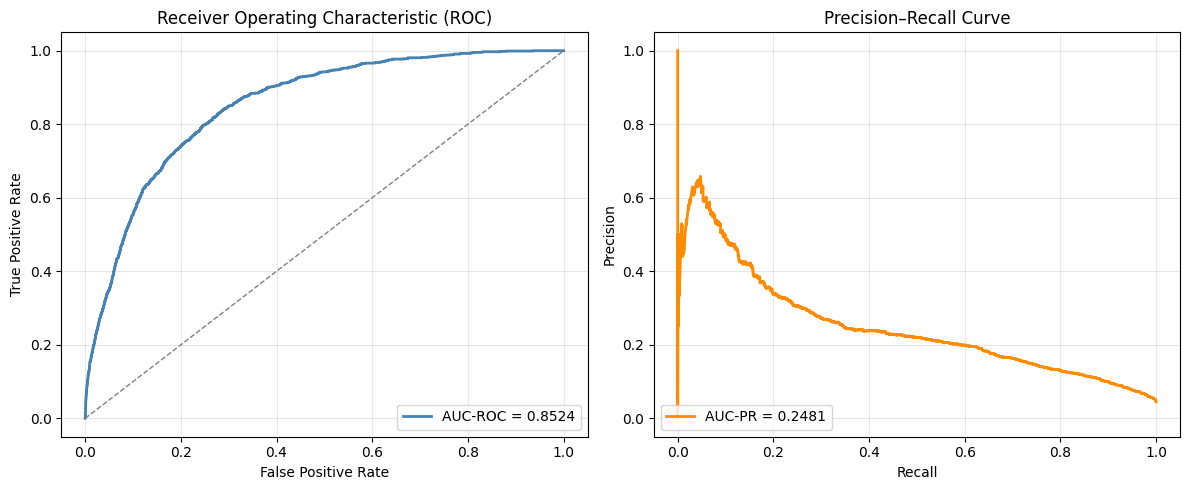

In [14]:
#PLOT AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_preds)
prec, rec, _ = precision_recall_curve(all_labels, all_preds)

auc_roc = auc(fpr, tpr)
auc_pr = auc(rec, prec)

plt.figure(figsize=(12, 5))

# --- ROC Curve ---
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='steelblue', lw=2, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# --- Precision-Recall Curve ---
plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='darkorange', lw=2, label=f"AUC-PR = {auc_pr:.4f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()

plt.show()

# Model with pos_weight

In [63]:

pos_count = (data["label"] == 1).sum()
neg_count = (data["label"] == 0).sum()
pos_weight = 1000
print(f"Using manual pos_weight = {pos_weight:.2f}")

model = SimpleM6Anet3x5()
opt = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.BCELoss(reduction='none')

# --------------------------------------------------
# 3️⃣ Training Loop
# --------------------------------------------------
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    progress = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for reads, seq, y in progress:
        reads, seq, y = reads, seq, y
        opt.zero_grad()
        
        preds = model(reads, seq)  # [B,1]
        preds = preds.view_as(y)

        # Apply pos_weight to positive samples
        weights = torch.where(y == 1, pos_weight, 1.0)
        loss = (loss_fn(preds, y) * weights).mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        total_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Train Loss: {total_loss/len(train_dl):.4f}")

Using manual pos_weight = 1000.00


KeyboardInterrupt: 

In [61]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for reads, seq, y in test_dl:
        preds = model(reads, seq)
        all_preds.append(preds.view(-1).cpu().numpy())
        all_labels.append(y.view(-1).cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

pred_labels = (all_preds > 0.5).astype(int)

acc = accuracy_score(all_labels, pred_labels)
prec = precision_score(all_labels, pred_labels, zero_division=0)
rec = recall_score(all_labels, pred_labels, zero_division=0)
f1 = f1_score(all_labels, pred_labels, zero_division=0)

auc_pr  = average_precision_score(all_labels, all_preds) if len(np.unique(all_labels)) > 1 else np.nan
auc_roc = roc_auc_score(all_labels, all_preds) if len(np.unique(all_labels)) > 1 else np.nan

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC-ROC  : {auc_roc:.4f}")
print(f"AUC-PR   : {auc_pr:.4f}")

print("\n--- Class Distribution ---")
unique, counts = np.unique(all_labels, return_counts=True)
print(dict(zip(unique, counts)))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, pred_labels)
print(cm)
print("(rows=true, cols=pred) → [[TN, FP], [FN, TP]]")

print("\n--- Classification Report ---")
print(classification_report(all_labels, pred_labels, digits=4))



=== Evaluation Metrics ===
Accuracy : 0.9541
Precision: 0.4645
Recall   : 0.1434
F1 Score : 0.2191
AUC-ROC  : 0.8623
AUC-PR   : 0.2792

--- Class Distribution ---
{0.0: 23273, 1.0: 1095}

--- Confusion Matrix ---
[[23092   181]
 [  938   157]]
(rows=true, cols=pred) → [[TN, FP], [FN, TP]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0     0.9610    0.9922    0.9763     23273
         1.0     0.4645    0.1434    0.2191      1095

    accuracy                         0.9541     24368
   macro avg     0.7127    0.5678    0.5977     24368
weighted avg     0.9387    0.9541    0.9423     24368



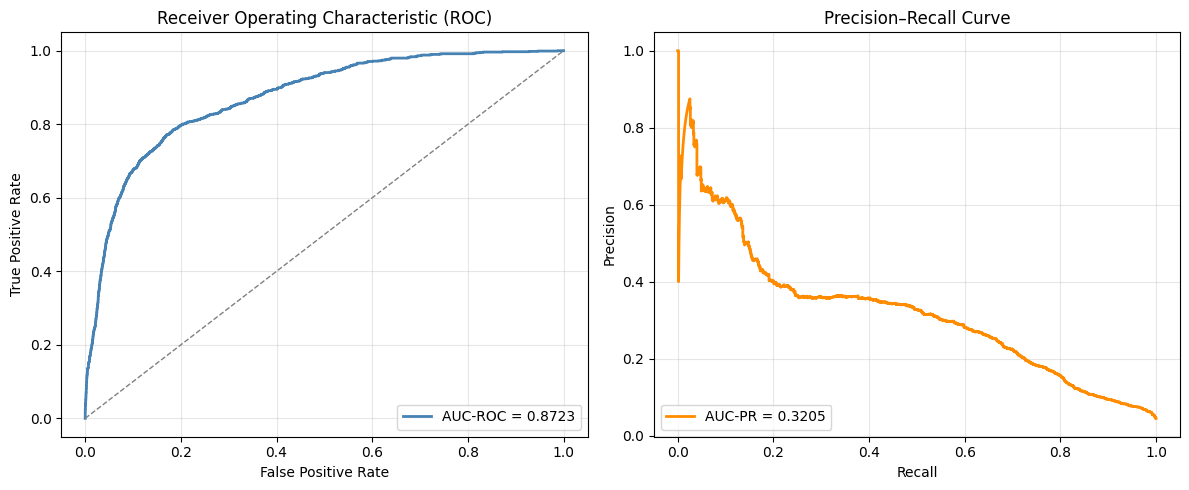

In [69]:
#PLOT AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_preds)
prec, rec, _ = precision_recall_curve(all_labels, all_preds)

auc_roc = auc(fpr, tpr)
auc_pr = auc(rec, prec)

plt.figure(figsize=(12, 5))

# --- ROC Curve ---
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='steelblue', lw=2, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# --- Precision-Recall Curve ---
plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='darkorange', lw=2, label=f"AUC-PR = {auc_pr:.4f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()

plt.show()

In [ ]:
#PLOT AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(all_labels, all_preds)
prec, rec, _ = precision_recall_curve(all_labels, all_preds)

auc_roc = auc(fpr, tpr)
auc_pr = auc(rec, prec)

plt.figure(figsize=(12, 5))

# --- ROC Curve ---
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='steelblue', lw=2, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# --- Precision-Recall Curve ---
plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='darkorange', lw=2, label=f"AUC-PR = {auc_pr:.4f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()

plt.show()

# TRANSFORMER FULL CODE (PLEASE CHALLENGE THE CODE THANKS!)

In [ ]:
# ============================================================
# SimpleM6Anet3x5-Transformer: FULL TRAINING PIPELINE
# ============================================================

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    precision_recall_curve
)

# ----------------------------
# 0) Utilities / config
# ----------------------------
SEED = 42
EPOCHS = 6
BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-4
LAMBDA_SPARSITY = 0.02   # tiny penalty to encourage sparse attention
USE_BALANCED_SAMPLER = False  # set True if you want balanced batches

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ----------------------------
# 1) Encoding and normalization
# ----------------------------
NUC2IDX = {'A':0, 'C':1, 'G':2, 'T':3}

def encode_3x5(seq_list):
    """Encode list of 3×5-mers into [3,5] integer tensor."""
    return torch.tensor([[NUC2IDX.get(b, 0) for b in kmer] for kmer in seq_list], dtype=torch.long)

def normalize_reads(reads, mean_vals, std_vals):
    """reads: list of [9] rows → np.array Nx9 normalized; at least one row guaranteed."""
    arr = np.array(reads, dtype=np.float32)
    if arr.ndim != 2 or arr.shape[1] != 9 or len(arr) == 0:
        arr = np.zeros((1, 9), dtype=np.float32)
    arr = (arr - mean_vals) / (std_vals + 1e-6)
    return arr

def pad_reads(reads_np):
    """Keep variable number of reads → torch.tensor [R,9]. Ensure at least one row."""
    if reads_np.ndim != 2 or reads_np.shape[1] != 9 or len(reads_np) == 0:
        reads_np = np.zeros((1, 9), dtype=np.float32)
    return torch.tensor(reads_np, dtype=torch.float32)

def collate_fn(batch):
    """
    Returns:
      reads: [B, Rmax, 9]
      seqs:  [B, 3, 5] (int)
      labels:[B, 1]
      mask:  [B, Rmax] bool (True for real reads)
    """
    reads_list, seqs_list, labels_list = zip(*batch)
    max_len = max(r.size(0) for r in reads_list)

    padded_reads, masks = [], []
    for r in reads_list:
        R = r.size(0)
        if R < max_len:
            pad = torch.zeros((max_len - R, r.size(1)), dtype=r.dtype)
            r = torch.cat([r, pad], dim=0)
        mask = torch.zeros(max_len, dtype=torch.bool)
        mask[:R] = True
        padded_reads.append(r)
        masks.append(mask)

    reads = torch.stack(padded_reads, dim=0)
    seqs  = torch.stack(seqs_list, dim=0)
    labels= torch.stack(labels_list, dim=0)

    return reads, seqs, labels, torch.stack(masks, dim=0)

# ----------------------------
# 2) Dataset
# ----------------------------
class RNASet3x5(Dataset):
    def __init__(self, df, mean_vals, std_vals):
        self.df = df.reset_index(drop=True)
        self.mean_vals = mean_vals
        self.std_vals = std_vals

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # normalize + tensorize reads
        reads_norm = normalize_reads(row["ThreePosReads"], self.mean_vals, self.std_vals)
        reads = pad_reads(reads_norm)                  # [R,9]
        # encode 3×5-mer
        seq  = encode_3x5(row["Three_5mers"])         # [3,5]
        # label
        y = torch.tensor([float(row["label"])], dtype=torch.float32)
        return reads, seq, y

# ----------------------------
# 3) Model
# ----------------------------
class SeqEmbedding3x5_Transformer(nn.Module):
    """
    Transformer encoder over the 3 positions; each position token = flattened 5-mer embeddings.
    """
    def __init__(self, vocab_size=4, emb_dim=16, k=5, num_pos=3, out_dim=32, n_heads=2, n_layers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, num_pos, k, emb_dim))  # learnable positional bias
        self.flatten_dim = k * emb_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.flatten_dim, nhead=n_heads,
            dim_feedforward=128, batch_first=True, dropout=0.1, activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, out_dim),
            nn.ReLU(),
        )

    def forward(self, seq):  # seq: [B,3,5] (int)
        e = self.emb(seq) + self.pos_emb            # [B,3,5,emb_dim]
        e = e.view(e.size(0), e.size(1), -1)        # [B,3, 5*emb_dim] = [B,3,D]
        e = self.encoder(e)                         # contextualize across positions
        e = e.mean(dim=1)                           # pool over the 3 tokens
        return self.fc(e)                           # [B, out_dim]

class ReadFeatureEncoder(nn.Module):
    """
    Sequence-conditioned read encoder with gating:
    reads [B,R,9] → project; seq_vec [B,S] → gate; elementwise product → MLP.
    """
    def __init__(self, input_dim=9, seq_dim=32, hidden_dim=128, out_dim=64, dropout=0.2):
        super().__init__()
        self.fc_seq   = nn.Linear(seq_dim, hidden_dim)
        self.fc_reads = nn.Linear(input_dim, hidden_dim)
        self.gate     = nn.Sigmoid()
        self.mlp = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU(),
        )

    def forward(self, reads, seq_vec):
        seq_h  = self.fc_seq(seq_vec).unsqueeze(1)     # [B,1,H]
        read_h = self.fc_reads(reads)                  # [B,R,H]
        gated  = read_h * self.gate(seq_h)             # [B,R,H]
        return self.mlp(gated)                         # [B,R,D]

class GatedAttentionMIL(nn.Module):
    """Ilse et al. (2018) gated attention for MIL; mask-aware."""
    def __init__(self, in_dim, att_dim=64):
        super().__init__()
        self.V = nn.Linear(in_dim, att_dim)
        self.U = nn.Linear(in_dim, att_dim)
        self.w = nn.Linear(att_dim, 1)

    def forward(self, H, mask=None):       # H: [B,R,D]
        A = torch.tanh(self.V(H)) * torch.sigmoid(self.U(H))  # [B,R,att_dim]
        a = self.w(A).squeeze(-1)                             # [B,R]
        if mask is not None:
            a = a.masked_fill(~mask, float('-inf'))
        att = torch.softmax(a, dim=1)                         # [B,R]
        M = torch.sum(att.unsqueeze(-1) * H, dim=1)           # [B,D]
        return M, att

class SimpleM6Anet3x5_Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # sequence encoder (transformer)
        self.seq_emb  = SeqEmbedding3x5_Transformer(
            vocab_size=4, emb_dim=16, k=5, num_pos=3, out_dim=32, n_heads=2, n_layers=1
        )
        # read encoder conditioned on sequence
        self.read_enc = ReadFeatureEncoder(input_dim=9, seq_dim=32, hidden_dim=128, out_dim=64, dropout=0.3)
        # attention pooling over reads
        self.att_pool = GatedAttentionMIL(in_dim=64, att_dim=64)
        # site head → logit
        self.site_head = nn.Linear(64, 1)

    def forward(self, reads, seq, mask=None):
        seq_vec   = self.seq_emb(seq)                 # [B,32]
        read_repr = self.read_enc(reads, seq_vec)     # [B,R,64]
        M, att    = self.att_pool(read_repr, mask)    # [B,64], [B,R]
        site_logit= self.site_head(M)                 # [B,1]
        return site_logit, att

# ----------------------------
# 4) Train / Eval
# ----------------------------
def train_one_epoch(model, dl, opt, loss_fn, epoch, lam_sparsity=0.0):
    model.train()
    total = 0.0
    for reads, seq, y, mask in tqdm(dl, desc=f"Train {epoch}"):
        reads, seq, y, mask = reads.to(device), seq.to(device), y.to(device), mask.to(device)
        opt.zero_grad()
        logits, att = model(reads, seq, mask)
        loss = loss_fn(logits, y)
        if lam_sparsity > 0:
            # Encourage sparse attention (few reads dominate)
            loss = loss + lam_sparsity * att.mean()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item()
    return total / max(1, len(dl))

@torch.no_grad()
def infer_logits(model, dl):
    model.eval()
    all_logits, all_labels = [], []
    for reads, seq, y, mask in dl:
        reads, seq, y, mask = reads.to(device), seq.to(device), y.to(device), mask.to(device)
        logits, _ = model(reads, seq, mask)
        all_logits.extend(logits.squeeze().cpu().tolist())
        all_labels.extend(y.squeeze().cpu().tolist())
    return np.array(all_logits), np.array(all_labels)

def evaluate_from_probs(labels, probs, thr=0.5, verbose=True, tag="Test"):
    preds = (probs > thr).astype(int)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    auc_roc = roc_auc_score(labels, probs)
    auc_pr  = average_precision_score(labels, probs)
    if verbose:
        print(f"\n=== {tag} Metrics (thr={thr:.3f}) ===")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1 Score : {f1:.4f}")
        print(f"AUC-ROC  : {auc_roc:.4f}")
        print(f"AUC-PR   : {auc_pr:.4f}")
        print("\nConfusion Matrix:\n", confusion_matrix(labels, preds))
        print("\nReport:\n", classification_report(labels, preds, digits=4))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc_roc":auc_roc, "auc_pr":auc_pr}

# ----------------------------
# 5) Data split and loaders
# ----------------------------
# Expect: `data` DataFrame is already in memory.
# If you still need to construct Three_5mers / ThreePosReads, build those first (as you did).

# Split: train / test
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=SEED, stratify=data["label"]
)

# Compute normalization ONLY on train
all_train_read_values = np.concatenate([np.array(r) for r in train_df["ThreePosReads"] if len(r) > 0])
mean_vals = all_train_read_values.mean(axis=0)
std_vals  = all_train_read_values.std(axis=0)
print("Train normalization mean/std:\n", mean_vals, "\n", std_vals)

# Build datasets
train_ds = RNASet3x5(train_df, mean_vals, std_vals)
test_ds  = RNASet3x5(test_df,  mean_vals, std_vals)

# Optional balanced sampler
if USE_BALANCED_SAMPLER:
    class_counts = train_df['label'].value_counts().to_dict()
    weights = train_df['label'].map(lambda x: 1.0/class_counts[x]).values
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn, num_workers=0)
else:
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)

test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# Small tuning split from train for picking threshold
tune_df, hold_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df["label"])
tune_ds = RNASet3x5(tune_df, mean_vals, std_vals)
hold_ds = RNASet3x5(hold_df, mean_vals, std_vals)
tune_dl = DataLoader(tune_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
hold_dl = DataLoader(hold_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# ----------------------------
# 6) Train
# ----------------------------
model = SimpleM6Anet3x5_Transformer().to(device)

# Class weight for BCEWithLogits
pos_count = int((train_df["label"] == 1).sum())
neg_count = int((train_df["label"] == 0).sum())
pos_weight = torch.tensor([neg_count / max(1, pos_count)], device=device, dtype=torch.float32)
print(f"Using pos_weight (neg/pos) = {pos_weight.item():.3f}")

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(1, EPOCHS+1):
    avg_loss = train_one_epoch(model, train_dl, opt, loss_fn, epoch, lam_sparsity=LAMBDA_SPARSITY)
    print(f"Epoch {epoch}/{EPOCHS} - Avg Train Loss: {avg_loss:.4f}")


# ----------------------------
# 8) Final evaluation on test
# ----------------------------
logits_test, labels_test = infer_logits(model, test_dl)
probs_test = torch.sigmoid(torch.tensor(logits_test)).numpy()
_ = evaluate_from_probs(labels_test, probs_test, thr=0.5, verbose=True, tag="Test")


Device: cpu
Train normalization mean/std:
 [8.10656862e-03 4.34904180e+00 1.10906130e+02 8.14551622e-03
 5.18487360e+00 1.11074772e+02 7.07642354e-03 2.98100289e+00
 8.62641050e+01] 
 [5.40921916e-03 2.57619424e+00 1.19108848e+01 5.29853237e-03
 3.00774585e+00 1.30165231e+01 4.38294195e-03 1.69948294e+00
 5.56063998e+00]
Using pos_weight (neg/pos) = 21.253


Train 1: 100%|██████████| 3046/3046 [03:17<00:00, 15.41it/s]


Epoch 1/6 - Avg Train Loss: 1.1399


Train 2: 100%|██████████| 3046/3046 [02:57<00:00, 17.17it/s]


Epoch 2/6 - Avg Train Loss: 1.0138


Train 3: 100%|██████████| 3046/3046 [02:49<00:00, 17.97it/s]


Epoch 3/6 - Avg Train Loss: 0.9778


Train 4: 100%|██████████| 3046/3046 [02:56<00:00, 17.29it/s]


Epoch 4/6 - Avg Train Loss: 0.9505


Train 5: 100%|██████████| 3046/3046 [03:08<00:00, 16.19it/s]


Epoch 5/6 - Avg Train Loss: 0.9378


Train 6: 100%|██████████| 3046/3046 [03:06<00:00, 16.33it/s]


Epoch 6/6 - Avg Train Loss: 0.9342


TypeError: 'float' object is not iterable

## Transformer Test


=== Test Metrics (thr=0.500) ===
Accuracy : 0.9389
Precision: 0.3880
Recall   : 0.6219
F1 Score : 0.4779
AUC-ROC  : 0.9047
AUC-PR   : 0.4103

Confusion Matrix:
 [[22199  1074]
 [  414   681]]

Report:
               precision    recall  f1-score   support

         0.0     0.9817    0.9539    0.9676     23273
         1.0     0.3880    0.6219    0.4779      1095

    accuracy                         0.9389     24368
   macro avg     0.6849    0.7879    0.7227     24368
weighted avg     0.9550    0.9389    0.9456     24368

AUC-ROC: 0.9047
AUC-PR:  0.4103


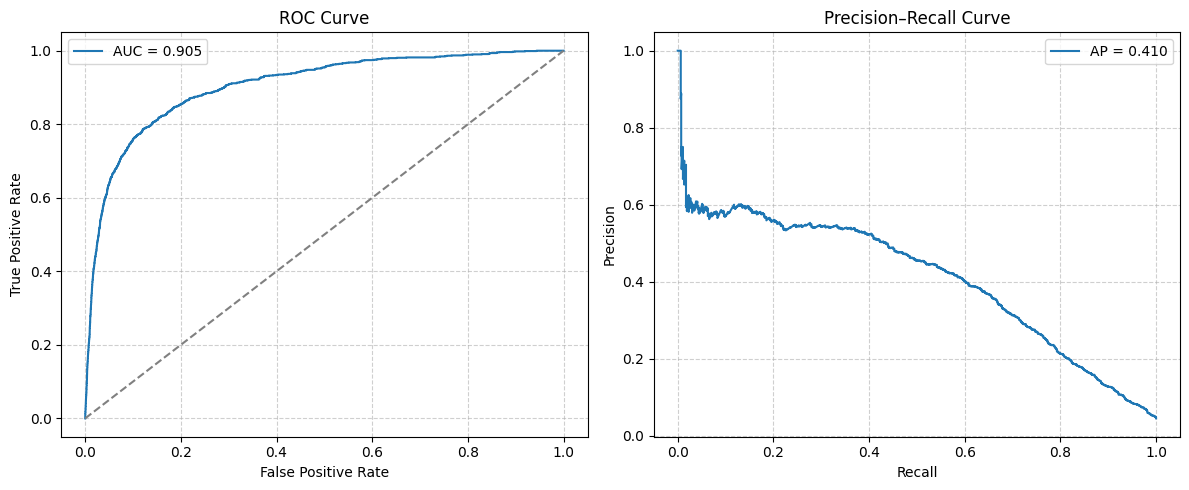

In [78]:
# ----------------------------
# 8) Final evaluation on test
# ----------------------------
logits_test, labels_test = infer_logits(model, test_dl)
probs_test = torch.sigmoid(torch.tensor(logits_test)).numpy()
_ = evaluate_from_probs(labels_test, probs_test, thr=0.5, verbose=True, tag="Test")

y_true = labels_test
y_score = probs_test  # assuming shape (N,)

# --- ROC ---
fpr, tpr, _ = roc_curve(y_true, y_score)
auc_roc = roc_auc_score(y_true, y_score)

# --- Precision–Recall ---
precision, recall, _ = precision_recall_curve(y_true, y_score)
auc_pr = average_precision_score(y_true, y_score)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR:  {auc_pr:.4f}")

# ============================================================
# Plot ROC and PR
# ============================================================
plt.figure(figsize=(12, 5))

# ---- ROC Curve ----
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# ---- PR Curve ----
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {auc_pr:.3f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Misclassification analysis

In [ ]:
import numpy as np

# ============================================================
# Inspect some raw prediction samples
# ============================================================
n_show = 10  # number of samples to print
thr = 0.5

# Flatten and ensure numpy arrays
y_true = np.array(labels_test).flatten()
y_prob = np.array(probs_test).flatten()
y_pred = (y_prob >= thr).astype(int)

# Choose a few random examples
idxs = np.random.choice(len(y_true), n_show, replace=False)

print("\n🔍 Sample predictions (thr = {:.2f})".format(thr))
print("-" * 60)
for i in idxs:
    print(f"Idx {i:>4d} | True: {y_true[i]} | Pred: {y_pred[i]} | Prob: {y_prob[i]:.4f}")
print("-" * 60)

# ============================================================
# Show misclassified examples
# ============================================================
mis_idx = np.where(y_pred != y_true)[0]
if len(mis_idx) > 0:
    print(f"\n❌ Misclassified samples ({len(mis_idx)} total):")
    show = np.random.choice(mis_idx, min(10, len(mis_idx)), replace=False)
    for i in show:
        print(f"Idx {i:>4d} | True: {y_true[i]} | Pred: {y_pred[i]} | Prob: {y_prob[i]:.4f}")
else:
    print("\n✅ No misclassifications (all correct at this threshold!)")




🔍 Sample predictions (thr = 0.50)
------------------------------------------------------------
Idx 6981 | True: 0.0 | Pred: 0 | Prob: 0.0442
Idx 11130 | True: 0.0 | Pred: 0 | Prob: 0.0703
Idx 19595 | True: 0.0 | Pred: 0 | Prob: 0.0528
Idx 18585 | True: 0.0 | Pred: 0 | Prob: 0.0179
Idx 1252 | True: 0.0 | Pred: 0 | Prob: 0.0176
Idx 19368 | True: 0.0 | Pred: 0 | Prob: 0.0035
Idx 4024 | True: 0.0 | Pred: 0 | Prob: 0.0157
Idx 1799 | True: 0.0 | Pred: 0 | Prob: 0.0489
Idx 5465 | True: 0.0 | Pred: 0 | Prob: 0.2541
Idx 21260 | True: 0.0 | Pred: 0 | Prob: 0.0178
------------------------------------------------------------

❌ Misclassified samples (1488 total):
Idx 2518 | True: 0.0 | Pred: 1 | Prob: 0.9122
Idx 16891 | True: 0.0 | Pred: 1 | Prob: 0.9660
Idx 14899 | True: 1.0 | Pred: 0 | Prob: 0.3446
Idx 2355 | True: 0.0 | Pred: 1 | Prob: 0.8491
Idx 17877 | True: 0.0 | Pred: 1 | Prob: 0.6723
Idx 4531 | True: 1.0 | Pred: 0 | Prob: 0.2618
Idx 11528 | True: 0.0 | Pred: 1 | Prob: 0.9903
Idx 17277 | T

In [106]:
import numpy as np

thr = 0.6
y_true = np.array(labels_test).flatten()
y_prob = np.array(probs_test).flatten()
y_pred = (y_prob >= thr).astype(int)

# Identify misclassifications
fp_idx = np.where((y_pred == 1) & (y_true == 0))[0]  # False Positives
fn_idx = np.where((y_pred == 0) & (y_true == 1))[0]  # False Negatives

print(f"\n⚠️ Misclassifications summary (thr = {thr}):")
print(f"  False Positives: {len(fp_idx)}")
print(f"  False Negatives: {len(fn_idx)}")

# ------------------------------------------------------------
# Show sample FP and FN examples
# ------------------------------------------------------------
def show_examples(idxs, label):
    if len(idxs) == 0:
        print(f"\n✅ No {label} found!")
        return
    print(f"\n❌ {label} examples ({len(idxs)} total):")
    show = np.random.choice(idxs, min(10, len(idxs)), replace=False)
    for i in show:
        print(f"Idx {i:>4d} | True: {y_true[i]} | Pred: {y_pred[i]} | Prob: {y_prob[i]:.4f}")

show_examples(fp_idx, "False Positives")
show_examples(fn_idx, "False Negatives")



⚠️ Misclassifications summary (thr = 0.6):
  False Positives: 855
  False Negatives: 473

❌ False Positives examples (855 total):
Idx 17284 | True: 0.0 | Pred: 1 | Prob: 0.9685
Idx 21286 | True: 0.0 | Pred: 1 | Prob: 0.8960
Idx 22780 | True: 0.0 | Pred: 1 | Prob: 0.9947
Idx 6393 | True: 0.0 | Pred: 1 | Prob: 0.6101
Idx 5408 | True: 0.0 | Pred: 1 | Prob: 0.8938
Idx 10140 | True: 0.0 | Pred: 1 | Prob: 0.7696
Idx 15961 | True: 0.0 | Pred: 1 | Prob: 0.6897
Idx 22400 | True: 0.0 | Pred: 1 | Prob: 0.9709
Idx 20402 | True: 0.0 | Pred: 1 | Prob: 0.7032
Idx 16596 | True: 0.0 | Pred: 1 | Prob: 0.6419

❌ False Negatives examples (473 total):
Idx 4515 | True: 1.0 | Pred: 0 | Prob: 0.3328
Idx  800 | True: 1.0 | Pred: 0 | Prob: 0.0984
Idx 10000 | True: 1.0 | Pred: 0 | Prob: 0.0553
Idx 6364 | True: 1.0 | Pred: 0 | Prob: 0.3058
Idx 3136 | True: 1.0 | Pred: 0 | Prob: 0.3195
Idx 9182 | True: 1.0 | Pred: 0 | Prob: 0.0323
Idx 15480 | True: 1.0 | Pred: 0 | Prob: 0.0479
Idx 8749 | True: 1.0 | Pred: 0 | Pro